In [ ]:
!pip install datasets
!pip install conllu

import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset

!pip install evaluate

import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import random as rd

In [ ]:
# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

In [ ]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_lines', split="test")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1032 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1035 [00:00<?, ? examples/s]

In [ ]:
# build a dictionary counting the number of occurrences of each type of the dataset
# and a list containing the number of word for each phrase
types = {}
phrase_lengths = []
for dataset in train_dataset, dev_dataset, test_dataset:
  for s in dataset:
    phrase_lengths.append(len(s['tokens']))
    for t in s['tokens']:
      types[t] = types.get(t, 0) + 1

Number of phrases:  5243
Number of non-projective phrases:  423
Numbert of types:  11096
Numbert of tokens:  94217
Average phrase length:  17.97
Top 10 most frequent types in the dataset:
-  ,     4970 occurrences
-  the   4780 occurrences
-  .     4709 occurrences
-  of    2228 occurrences
-  to    2191 occurrences
-  and   2181 occurrences
-  a     2153 occurrences
-  in    1338 occurrences
-  was   1117 occurrences
-  I      981 occurrences


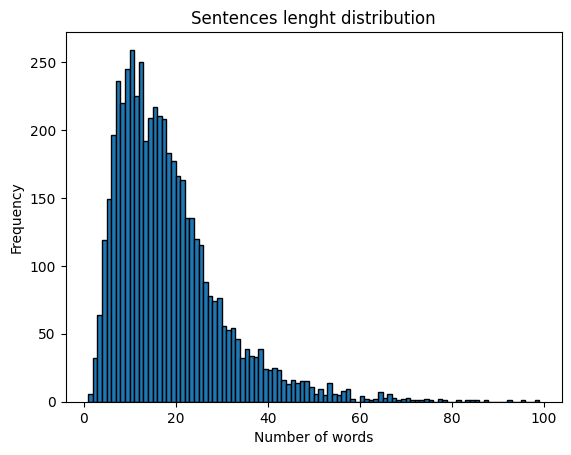

In [ ]:
train_dataset = [sample for sample in train_dataset if 'None' not in sample["head"]]
dev_dataset = [sample for sample in dev_dataset if 'None' not in sample["head"]]
test_dataset = [sample for sample in test_dataset if 'None' not in sample["head"]]
print('Number of phrases: ',len(train_dataset) + len(dev_dataset) + len(test_dataset))

non_proj_train = [sample for sample in train_dataset if not is_projective([-1] + [int(head)for head in sample["head"]] + [-1])]
non_proj_dev = [sample for sample in dev_dataset if not is_projective([-1] + [int(head) for head in sample["head"]] + [-1])]
non_proj_test = [sample for sample in test_dataset if not is_projective([-1] + [int(head) for head in sample["head"]] + [-1])]
print('Number of non-projective phrases: ',len(non_proj_train) + len(non_proj_dev) + len(non_proj_test))

print('Numbert of types: ', len(types))
print('Numbert of tokens: ', sum(phrase_lengths))
print(f'Average phrase length:  {sum(phrase_lengths)/len(phrase_lengths):.2f}')

most_frequent_types = sorted(types.items(), key=lambda x: x[1], reverse=True)[:10]

print('Top 10 most frequent types in the dataset:')
for key, value in most_frequent_types:
    print(f'-  {key:5}{value:5} occurrences')

plt.hist(phrase_lengths, bins=range(min(phrase_lengths), max(phrase_lengths) + 2), edgecolor='black')

plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Sentences lenght distribution')

plt.show()

In [ ]:
def spanAnalysis(dataset, dictionary):
  for sample in dataset:
    tree = [-1] + [int(i) for i in sample["head"]]
    if not is_projective(tree):
      continue
    for index, head in enumerate(tree):
      if head == -1:
        continue
      key = abs(head-index-1)
      dictionary[key] = dictionary.get(key, 0) + 1
  return dictionary

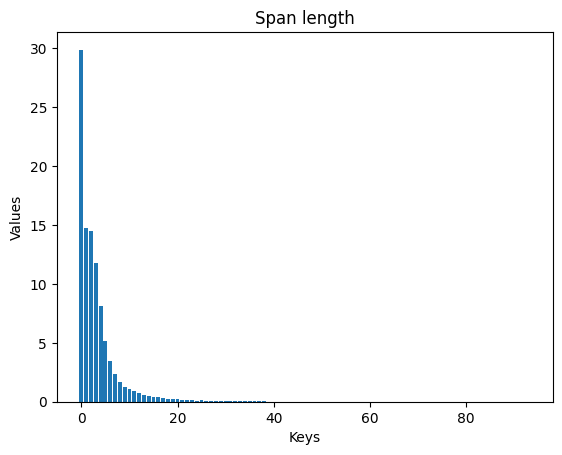

In [ ]:
my_dict = {}
spanAnalysis(train_dataset, my_dict)
spanAnalysis(dev_dataset, my_dict)
spanAnalysis(test_dataset, my_dict)

total_sum = 0
for value in my_dict.values():
  total_sum += value
for key in my_dict.keys():
  my_dict[key] = 100 * my_dict[key]/total_sum

# Extract keys and values
keys = list(my_dict.keys())
values = list(my_dict.values())

# Create a histogram
plt.bar(keys, values)

# Adding labels and title
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Span length')

# Show the histogram
plt.show()

In [ ]:
#for key in sorted(my_dict.keys()):
  #print("key ", key, ": ", my_dict[key])

In [ ]:
class ArcStandard:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # three shift moves to initialize the stack
    self.shift()
    self.shift()
    if len(self.sentence) > 2:
      self.shift()

    self.loss = [0 for i in range(len(self.stack))]

  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  def left_arc(self):
    o1 = self.stack.pop()
    o2 = self.stack.pop()
    self.arcs[o2] = o1
    self.stack.append(o1)
    if len(self.stack) < 2 and len(self.buffer) > 0:
      self.shift()

  def right_arc(self):
    o1 = self.stack.pop()
    o2 = self.stack.pop()
    self.arcs[o1] = o2
    self.stack.append(o2)
    if len(self.stack) < 2 and len(self.buffer) > 0:
      self.shift()

  def is_tree_final(self):
    return len(self.stack) == 1 and len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.loss)
    print(self.arcs)

In [ ]:
class StaticOracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    s1 = self.parser.stack[len(self.parser.stack)-1]
    s2 = self.parser.stack[len(self.parser.stack)-2]

    if self.gold[s2] == s1:
      return True

    return False

  def is_right_arc_gold(self):
    s1 = self.parser.stack[len(self.parser.stack)-1]
    s2 = self.parser.stack[len(self.parser.stack)-2]

    if self.gold[s1] != s2:
      return False

    #we only check missing dependents for sigma_1 to the right
    #since we assume A is correct and thus all left dependents
    #for sigma_1 have already been collected
    for i in self.parser.buffer:
      if self.gold[i] == s1:
        return False

    return True

  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold()):
      return False

    return True

In [ ]:
# Approximated Dynamic Oracle
class DynamicOracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree
    # Two element list: the first one represents the type of transition that took place in the previous step, the second is the cost of that transition
    self.previous_action = [-1, 0]

  def cost_left_arc(self):
    # If the transition is illegal the returned cost is infinite
    if len(self.parser.stack) < 2 or (len(self.parser.stack) == 2 and len(self.parser.buffer) != 0) or self.parser.stack[-2] == 0:
      return float('inf')

    cost  = 0
    s1 = self.parser.stack[len(self.parser.stack)-1]
    s2 = self.parser.stack[len(self.parser.stack)-2]

    # If the transition generates a gold arcs we lower its cost by 1: while
    # checking for a possible actual parent in the stack the same arc will be
    # counted zeroing the cost of the transition, so that if all the dependent
    # children has been collected, the cost of the transition is 0 since no gold
    # arcs have been lost.
    if self.gold[s2] == s1:
      cost -= 1

    # Check remaining gold arcs in the stack
    for i in self.parser.stack:
      if self.gold[i] == s2 or self.gold[s2] == i:
        cost += 1

    # Check remaining gold arcs in the buffer
    for i in self.parser.buffer:
      if self.gold[i] == s2 or self.gold[s2] == i:
        cost += 1

    # Discount the cost of the pevious transition if it was a shift
    if self.previous_action[0] == 2:
      cost -= self.previous_action[1]

    return cost

  def cost_right_arc(self):
    # If the transition is illegal the returned cost is infinite
    if len(self.parser.stack) < 2 or (self.parser.stack[-2] == 0 and len(self.parser.buffer) != 0):
      return float('inf')

    cost  = 0

    s1 = self.parser.stack[len(self.parser.stack)-1]
    s2 = self.parser.stack[len(self.parser.stack)-2]

    if self.gold[s1] == s2:
      cost -= 1

    for i in self.parser.stack:
      if self.gold[i] == s1 or self.gold[s1] == i:
        cost += 1

    for i in self.parser.buffer:
      if self.gold[i] == s1 or self.gold[s1] == i:
        cost += 1

    if self.previous_action[0] == 2:
      cost -= self.previous_action[1]

    return cost

  def cost_shift(self):
    # If the transition is illegal the returned cost is infinite
    if len(self.parser.buffer) == 0:
      return float('inf')

    cost = 0
    s1 = self.parser.stack[-1]

    # CASE 1: s1 has a right child
    for i in self.parser.buffer:
      if self.gold[i] == s1:
        return cost # a right child allows a costless shift

    # CASE 2: s1 is a right child without right children
    if self.gold[s1] < s1:
      b1 = self.parser.buffer[0]
      sacrifice = 0
      # search for a lost father so that we can create an arc between s1 and the orphan node
      orphan = False
      father = self.gold[b1]

      while not orphan and father != 0:
        flag = father in self.parser.stack
        if (father not in self.parser.buffer and not flag):
          orphan = True
        # one of the forefathers of b1 (except the <ROOT>) is in the stack: we can sacrifice that gold arc attaching the dependent to s1 instead of its actual parent
        if flag:
          return 1
        # the brach of the parsing tree containing b1 is contained in the buffer: we continue in the search of an orphan
        father = self.gold[father]

      # A previous wrong transition made a token an orphan: if we correctly
      # generate the parsing tree branch with that orphan as root, then we can
      # attach it as dependent of s1 without making additional errors.
      if orphan:
        return 0

      # There is no orphan between the <ROOT> and b1: let's see how many gold arcs directly involve b1
      for i in self.parser.stack:
        if self.gold[i] == b1 or self.gold[b1] == i:
          sacrifice += 1
      for i in self.parser.buffer:
        if self.gold[i] == b1 or self.gold[b1] == i:
          sacrifice += 1

      # Being a right child without right children there is no need to check for gold arcs between s1 and tokens in the buffer
      for i in self.parser.stack:
        if self.gold[i] == s1 or self.gold[s1] == i:
          cost += 1

      return min(cost, sacrifice)

    # CASE 3: s1 is a left child with no right children
    for i in self.parser.stack:
      if self.gold[i] == s1:
        cost += 1

    return cost

  def provideTransitionCosts(self):
    return [self.cost_left_arc(), self.cost_right_arc(), self.cost_shift()]

In [ ]:
# Exact Dynamic Oracle
class ExactDynamicOracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree
    self.current_cost = computeLoss(self.parser, self.gold)

  def cost_left_arc(self):
    #print("LEFT_ARC")
    if len(self.parser.stack) < 2 or (len(self.parser.stack) == 2 and len(self.parser.buffer) != 0) or self.parser.stack[len(self.parser.stack)-2] == 0:
      return float('inf')

    fake_parser = copy.deepcopy(self.parser)
    if self.gold[fake_parser.stack[-2]] != fake_parser.stack[-1]:
      fake_parser.loss[-1] += 1
    fake_parser.loss[-1] += fake_parser.loss.pop(-2)
    fake_parser.left_arc()
    new_cost = computeLoss(fake_parser, self.gold)
    return new_cost - self.current_cost

  def cost_right_arc(self):
    #print("RIGHT_ARC")
    if len(self.parser.stack) < 2 or (self.parser.stack[-2] == 0 and len(self.parser.buffer) > 0):
      return float('inf')

    #current_cost = computeLoss(self.parser, self.gold)
    fake_parser = copy.deepcopy(self.parser)
    if self.gold[fake_parser.stack[-1]] != fake_parser.stack[-2]:
      fake_parser.loss[-2] += 1
    if len(fake_parser.loss) > 2:
      tmp = fake_parser.loss[-2] + fake_parser.loss[-1]
      fake_parser.loss[-2] = tmp
    else:
      fake_parser.loss[0] += fake_parser.loss[1]
    #fake_parser.print_configuration()
    fake_parser.loss.pop()
    fake_parser.right_arc()

    new_cost = computeLoss(fake_parser, self.gold)

    #print("CC: ", current_cost, " NC: ", new_cost)
    return new_cost - self.current_cost

  def cost_shift(self):
    #print("SHIFT")
    if len(self.parser.buffer) == 0:
      return float('inf')
    #current_cost = computeLoss(self.parser, self.gold)
    fake_parser = copy.deepcopy(self.parser)
    fake_parser.shift()
    fake_parser.loss.append(0)
    new_cost = computeLoss(fake_parser, self.gold)

    return new_cost - self.current_cost

  def provideTransitionCosts(self):
    #print("CURRENT")
    #self.current_cost = computeLoss(self.parser, self.gold)
    #print("------------------------------------------------")
    return [self.cost_left_arc(), self.cost_right_arc(), self.cost_shift()]

In [ ]:
# Auxiliary functions for the Exact Dynamic Oracle
def computeLoss(parser, gold):
  b = len(parser.stack)
  gamma = parser.stack + parser.buffer
  table = [[{} for _ in range(len(gamma))] for _ in range(len(gamma))]
  #parser.print_configuration()
  # Table initialization
  j = 0
  for i in range(len(gold)):
    #print("token ", i, " parent: ", parser.arcs[i])
    if parser.arcs[i] != -1:
      continue
    if j < b: # Initialize table entries for diagonal elements coming from the stack
      table[j][j] = {j: [parser.loss[j], i]}
      j += 1
    elif j < len(gamma) and j >= b: # Initialize table entries for diagonal elements coming from the buffer
      table[j][j] = {j: [0, i]}
      j += 1

  # Fill in the remaining table entries
  for j in range(b - 1, len(gamma)):
    #print("j: ", j)
    for i in range(j, -1, -1):
      #print("\ti: ", i)
      fillTableEntry(table, i, j, gold)

  #print("Table final cell: ", dict(sorted(table[0][len(gamma) - 1].items())))

  return table[0][len(gamma) - 1][0][0] #min(table[0][len(gamma) - 1], key=lambda k: table[0][len(gamma) - 1][k])

def checkGold(head, dependent, gold):
  if gold[dependent] == head:
    return 0
  else:
    return 1

def fillTableEntry(table, i, j, gold):
  for k in range(i, j):  # Loop over possible split points in the interval [i, j-1]
    #print("\t\tk: ", k)
    #print("\t\t\ttable[i][k]: ", table[i][k])
    #print("\t\t\ttable[k+1][j]", table[k+1][j])
    for key_left in table[i][k]:
      for key_right in table[k+1][j]:
        value_right = table[i][j].get(key_right, (float('inf'), None))
        value_left = table[i][j].get(key_left, (float('inf'), None))

        loss_left_arc = table[i][k][key_left][0] + table[k+1][j][key_right][0] + checkGold(table[k+1][j][key_right][1], table[i][k][key_left][1], gold)
        if value_right[0] == float('inf'):
          table[i][j][key_right] = [min(loss_left_arc, value_right[0]), table[k+1][j][key_right][1]]
        else:
          table[i][j][key_right][0] = min(loss_left_arc, value_right[0])
          table[i][j][key_right][1] = table[k+1][j][key_right][1]

        loss_right_arc = table[i][k][key_left][0] + table[k+1][j][key_right][0] + checkGold(table[i][k][key_left][1], table[k+1][j][key_right][1], gold)
        if value_left[0] == float('inf'):
          table[i][j][key_left] = [min(loss_right_arc, value_left[0]), table[i][k][key_left][1]]
        else:
          table[i][j][key_left][0] = min(loss_right_arc, value_left[0])
          table[i][j][key_left][1] = table[i][k][key_left][1]

        #print("\t\t\t\ttable[i][j]: ", table[i][j])

In [ ]:
def perform(action, parser, oracle, gold_tree, costs):
  if action == 0:
    parser.left_arc()
    oracle.previous_action = [0, costs[0]]

  elif action == 1:
    parser.right_arc()
    oracle.previous_action = [1, costs[1]]

  elif action == 2:
    parser.shift()
    oracle.previous_action = [2, costs[2]]

def parse_dataset(dataset):
  for sample in dataset:
    sentence = ['<ROOT>'] + sample['tokens']
    gold_tree = sample['head']
    gold_tree = [-1] + [int(key) for key in gold_tree]

    if not is_projective(gold_tree): # the parser does not work with non-projective tree
      continue
    parser = ArcStandard(sentence)
    oracle = ExactDynamicOracle(parser, gold_tree)
    while not parser.is_tree_final():
      costs = oracle.provideTransitionCosts()
      action = np.argmin(costs)
      #print(action)
      #print(oracle.provideTransitionCosts())
      perform(action, parser, oracle, gold_tree, costs)
    #print("STOP")
    parse_tree = parser.arcs
    if parse_tree != gold_tree:
      return False
  return True

print(parse_dataset(train_dataset))

True


In [ ]:
# remove the non projective trees in the train dataset
#train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]

# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

In [ ]:
def process_sample(sample, get_gold_path = False):

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  return enc_sentence, sentence, gold

In [ ]:
def prepare_batch(batch_data):
  data = [process_sample(s) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  enc_sentences = [s[0] for s in data] # input_ids
  sentences = [s[1] for s in data] # sentences
  trees = [s[2] for s in data] # gold_tree
  return enc_sentences, sentences, trees

In [ ]:
BATCH_SIZE = 32

bilstm_train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch))
bilstm_dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
bilstm_test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

In [ ]:
EMBEDDING_SIZE = 200
LSTM_SIZE = 200
LSTM_LAYERS = 2
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 15
LR = 0.001   # learning rate
PROBABILITY_THRESHOLD = 0.1

In [ ]:
class BilstmParser(nn.Module):

  def __init__(self, device):
    super(BilstmParser, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(8*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 3, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)

    #self.x = []
    self.h = torch.zeros(1,1,1)

  def forward(self, x, paths, flag_enc, flag_feat):
    if flag_enc:
      # get the embeddings
      x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]
      #if flag_feat:
      # run the bi-lstm
      self.h = self.lstm_pass(x) # size(longest_sentence, batch_size, features)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, self.h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      mlp_input.append(torch.cat([zero_tensor if configurations[i][0] == -1 else h[configurations[i][0]][i], zero_tensor if configurations[i][1] == -1 else h[configurations[i][1]][i], zero_tensor if configurations[i][2]==-1 else h[configurations[i][2]][i], zero_tensor if configurations[i][3] == -1 else h[configurations[i][3]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcStandard(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def exctract_bilstm_configuration(self, x, stack, buffer, done, flag_new_enc=False):

    if flag_new_enc:
      x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]
      self.h = self.lstm_pass(x)

    configurations = self.get_configurations_RL(stack, buffer, done)
    mlp_input = self.get_mlp_input([configurations], self.h)

    # return the predicted dependency tree
    return mlp_input

  def get_configurations_RL(self, stack, buffer, done):
    conf = []

    if done:
      conf = [-1, -1, -1, -1]
    else:
      if len(stack) == 0:
        conf = [-1, -1, -1]
      elif len(stack) == 1:
        conf = [-1, -1, stack[-1]]
      elif len(stack) == 2:
        conf = [-1, stack[-2], stack[-1]]
      else:
        conf = [stack[-3], stack[-2], stack[-1]]
      if len(buffer) == 0:
        conf.append(-1)
      else:
        conf.append(buffer[0])

    return conf

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1, -1]
      else:
        if len(parser.stack) == 0:
          conf = [-1, -1, -1]
        elif len(parser.stack) == 1:
          conf = [-1, -1, parser.stack[-1]]
        elif len(parser.stack) == 2:
          conf = [-1, parser.stack[-2], parser.stack[-1]]
        else:
          conf = [parser.stack[-3], parser.stack[-2], parser.stack[-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append(conf)

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # in this function we select and perform the next move according to the scores obtained.
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        if moves_argm[i] == 0:
          if parsers[i].stack[-2] != 0:
            parsers[i].left_arc()
          else:
            if len(parsers[i].buffer) > 0:
              parsers[i].shift()
            else:
              parsers[i].right_arc()
        elif moves_argm[i] == 1:
          if parsers[i].stack[-2] == 0 and len(parsers[i].buffer)>0:
            parsers[i].shift()
          else:
            parsers[i].right_arc()
        elif moves_argm[i] == 2:
          if len(parsers[i].buffer) > 0:
            parsers[i].shift()
          else:
            if moves[i][0] > moves[i][1]:
              if parsers[i].stack[-2] != 0:
                parsers[i].left_arc()
              else:
                parsers[i].right_arc()
            else:
              parsers[i].right_arc()

In [ ]:
def find_min_indices(nums):
  min_value = min(nums)
  min_indices = [i for i, num in enumerate(nums) if num == min_value]
  return min_indices

def execute(parsers, actions, oracles, costs):
  for parser, action, oracle, cost in zip(parsers, actions, oracles, costs):
    if parser.is_tree_final():
      continue
    else:
      if action == 0:
        parser.left_arc()
        oracle.previous_action = [0, cost[0]]
      elif action == 1:
        parser.right_arc()
        oracle.previous_action = [1, cost[1]]
      elif action == 2:
        parser.shift()
        oracle.previous_action = [2, cost[2]]

def executeExatDynamicOracle(actions, parsers, gold_trees):
  for parser, action, gold_tree in zip(parsers, actions, gold_trees):
    if parser.is_tree_final():
      continue
    else:
      if action == 0:
        if gold_tree[parser.stack[-2]] != parser.stack[-1]:
          parser.loss[-1] += 1
        parser.loss[-1] += parser.loss.pop(-2)
        parser.left_arc()

      elif action == 1:
        if gold_tree[parser.stack[-1]] != parser.stack[-2]:
          parser.loss[-2] += 1
        if len(parser.loss) > 2:
          tmp = parser.loss[-2] + parser.loss[-1]
          parser.loss[-2] = tmp
        else:
          parser.loss[0] += parser.loss[1]
        parser.loss.pop()
        parser.right_arc()

      elif action == 2:
        parser.loss.append(0)
        parser.shift()

def choose_next_amb(iteration, transition, min_cost):
  if transition in min_cost:
    return transition
  else:
    return min_cost[rd.randint(0, len(min_cost) - 1)]

def choose_next_exp(iteration, transition, min_cost):
  if iteration >= 1 and rd.random() > PROBABILITY_THRESHOLD:
    return transition
  else:
    return choose_next_amb(iteration, transition, min_cost)

def parsed_all(parsers):
  for parser in parsers:
    if not parser.is_tree_final():
      return False
  return True

In [ ]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

def train(model, dataloader, criterion, optimizer, epoch, device):
  model.train()
  total_loss = 0
  count = 0
  error_count = 0

  # For each batch
  for batch in dataloader:
    # Extract sentence enconding, sentence itself and gold tree for each sentence in the batch
    enc_sentences, sentences, trees = batch
    # Reset the gradient for the current batch
    optimizer.zero_grad()
    # Containers to store transitions scores and respective gold labels
    global_transitions_scores = []
    global_gold_transitions = []

    # Flag to tell the model whether to save the encodings and the features tensor h for a new batch or not
    flag_enc = True
    flag_feat = True
    # Initialize a parser and an oracle for each sentence in the batch
    parsers = [ArcStandard(s) for s in sentences]

    # CHANGE ORACLE CLASS HERE
    oracles = [DynamicOracle(parser, tree) for parser, tree in zip(parsers, trees)]

    # While each sentence hasn't been fully parsed
    while not parsed_all(parsers):

      # Save configuration: later we'll need the sequence of configurations in order to associate each one to the correct transition
      configurations = []
      for parser in parsers:
        if parser.is_tree_final():
          configurations.append([-1, -1, -1, -1])
        else:
          if len(parser.stack) == 0:
            configurations.append([-1, -1, -1])
          elif len(parser.stack) == 1:
            configurations.append([-1, -1, parser.stack[-1]])
          elif len(parser.stack) == 2:
            configurations.append([-1, parser.stack[-2], parser.stack[-1]])
          else:
            configurations.append([parser.stack[-3], parser.stack[-2], parser.stack[-1]])
          if len(parser.buffer) == 0:
            configurations[-1].append(-1)
          else:
            configurations[-1].append(parser.buffer[0])

      # The model produce the scores for each transition given the current configuration
      transitions_scores_tensor = model(enc_sentences, configurations, flag_enc, flag_feat)
      transitions_scores = transitions_scores_tensor.cpu().detach().numpy()
      flag_enc = False
      flag_feat = False
      # Cost of each transition for each current configuration
      costs = [oracle.provideTransitionCosts() for oracle in oracles]

      # Legal transitions for each current configuration
      legal_moves = [[index for index, value in enumerate(cost) if value != float('inf')] for cost in costs]

      # Legal transition with higher score according to the model for each current configuration
      predicted_transition = [moves[np.argmax([scores[i] for i in moves])] if not parser.is_tree_final() else -1 for scores, moves, parser in zip(transitions_scores, legal_moves, parsers)]

      # Collect the set of transitions with minimum cost for each current configuration
      min_cost_transitions = [find_min_indices(cost) for cost in costs]

      # Collect the best scoring transition among the ones with minimum cost for each current configuration
      best_min_cost_transitions = [
        max(
        (score, i) for i, score in enumerate(scoring_quadruplet) if i in min_cost_transition
        )[1]
        for scoring_quadruplet, min_cost_transition in zip(transitions_scores, min_cost_transitions)
      ]

      # Select a transition: the one predicted by the model or a randomly chosen one from the set of minimum cost transitions
      actual_transitions = [choose_next_exp(epoch, predicted_transition[i], min_cost_transitions[i]) for i in range(len(predicted_transition))]

      # Check if the predicted transition is among the ones with minimum cost: if not we need to update the model
      for i, parser in enumerate(parsers):
        if not parser.is_tree_final():# and predicted_transition[i] not in min_cost_transitions[i]:
          global_transitions_scores.append(transitions_scores_tensor[i])
          global_gold_transitions.append(best_min_cost_transitions[i])

      # Perform the decided transition
      execute(parsers, actual_transitions, oracles, costs)
      #executeExatDynamicOracle(actual_transitions, parsers, trees)

    if len(global_transitions_scores) != 0:
      global_transitions_scores = torch.stack(global_transitions_scores).to(device)
      loss = criterion(global_transitions_scores, torch.tensor(np.array(global_gold_transitions)).to(device))
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      count +=1

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    enc_sentences, sentences, trees = batch
    with torch.no_grad():
      pred = model.infere(enc_sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
BiLSTM_model = BilstmParser(device)
BiLSTM_model.to(device)
'''
for name, param in BiLSTM_model.named_parameters():
  if 'weight' in name:
    print(f"Layer Name: {name}")
    print(param)
    print("\n")
'''
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(BiLSTM_model.parameters(), lr=LR)

# lists to store losses and scores for later being put into the graphs
bilstm_losses = []
bilstm_scores = []

start = time.time()

for epoch in range(EPOCHS):
  avg_train_loss = train(BiLSTM_model, bilstm_train_dataloader, criterion, optimizer, epoch, device)
  val_uas = test(BiLSTM_model, bilstm_dev_dataloader)

  bilstm_losses.append(avg_train_loss)
  bilstm_scores.append(val_uas)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

end = time.time()

# Save the trained model weights
torch.save(BiLSTM_model.state_dict(), 'bilstm_model_weights.pth')

# minutes of training time
bilstm_training_time = (end - start)/60

Device: cuda
Epoch:   0 | avg_train_loss: 0.815 | dev_uas: 0.555 |
Epoch:   1 | avg_train_loss: 0.705 | dev_uas: 0.624 |
Epoch:   2 | avg_train_loss: 0.693 | dev_uas: 0.642 |
Epoch:   3 | avg_train_loss: 0.685 | dev_uas: 0.642 |
Epoch:   4 | avg_train_loss: 0.674 | dev_uas: 0.661 |
Epoch:   5 | avg_train_loss: 0.669 | dev_uas: 0.684 |
Epoch:   6 | avg_train_loss: 0.665 | dev_uas: 0.682 |
Epoch:   7 | avg_train_loss: 0.661 | dev_uas: 0.697 |
Epoch:   8 | avg_train_loss: 0.657 | dev_uas: 0.704 |
Epoch:   9 | avg_train_loss: 0.653 | dev_uas: 0.707 |
Epoch:  10 | avg_train_loss: 0.650 | dev_uas: 0.708 |
Epoch:  11 | avg_train_loss: 0.645 | dev_uas: 0.717 |
Epoch:  12 | avg_train_loss: 0.642 | dev_uas: 0.725 |
Epoch:  13 | avg_train_loss: 0.638 | dev_uas: 0.732 |
Epoch:  14 | avg_train_loss: 0.636 | dev_uas: 0.735 |


BiLSTM training time: 16.20 min
Test set UAS score BiLSTM: 0.739


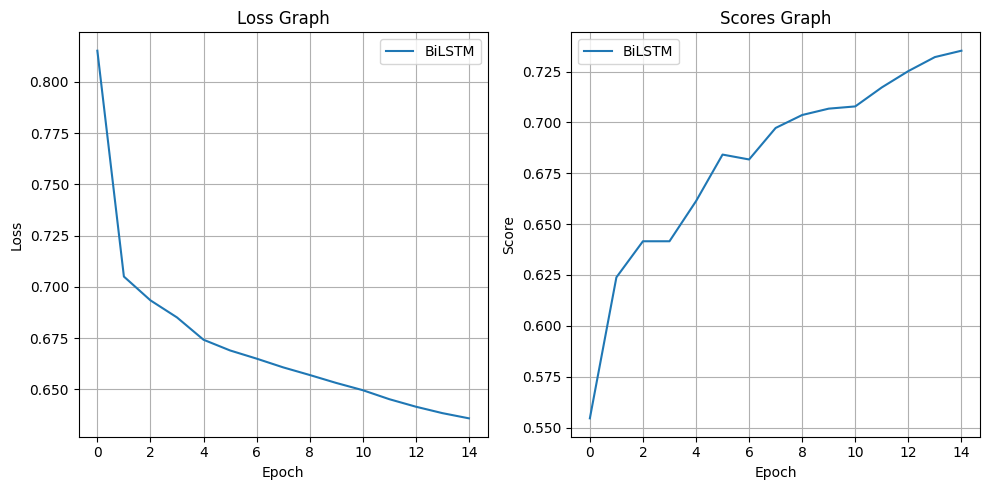

In [ ]:
print(f'BiLSTM training time: {bilstm_training_time:4.2f} min')

bilstm_test_uas = test(BiLSTM_model, bilstm_test_dataloader)
print(f'Test set UAS score BiLSTM: {bilstm_test_uas:5.3f}')

# plotting the graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(bilstm_losses, label='BiLSTM')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax1.set_title('Loss Graph')
ax1.grid(True)
ax1.legend()

ax2.plot(bilstm_scores, label='BiLSTM')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')

ax2.set_title('Scores Graph')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

plt.show()